In [21]:
from copy import deepcopy
from pathlib import Path

import torch
import numpy as np
from torchvision import models

from cuticulus.datasets import BackgroundSub
from cuticulus.mlutils.torch import TorchDS

In [2]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

In [3]:
device = torch.device("cuda:4")

In [4]:
patch_size = (32, 32)
ds = BackgroundSub(
    size=patch_size,
)
ds.images = ds.images.transpose(0, 3, 1, 2)
ds.images = ds.images.astype(np.float32)

[17:54:25] Loaded labels.                                                       ]8;id=821202;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=244869;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#89\89]8;;\

           Loaded dataset.                                                     ]8;id=897026;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=307577;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#114\114]8;;\

           Unique images considered: 48765                                     ]8;id=362132;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=3203;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#135\135]8;;\

           Samples per class:                                                  ]8;id=219807;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=94095;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 46999                                                            ]8;id=610558;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=133886;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 1766                                                             ]8;id=790841;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=739512;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

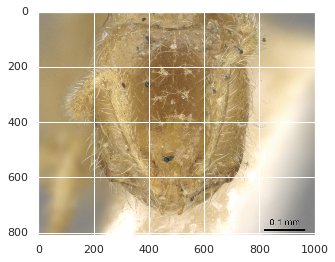

In [5]:
img = ds.get_image(1001)
plt.imshow(img)

In [6]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(
    './output/models/1651873789/model.pth',
    map_location=device,
))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
imgs = []
for row in range(0, img.shape[0] - patch_size[0] + 1, patch_size[0]):
    for col in range(0, img.shape[1] - patch_size[1] + 1, patch_size[1]):
        x0, y0 = row, col
        x1, y1 = x0 + patch_size[0], y0 + patch_size[1]
        imgs.append(img[x0:x1, y0:y1])
imgs = np.array(imgs).astype(np.float32)
imgs = imgs.transpose(0, 3, 1, 2)

In [8]:
imgs.shape

(775, 3, 32, 32)

In [9]:
loader = torch.utils.data.DataLoader(
    TorchDS(imgs, np.zeros(imgs.shape[0])),
    batch_size=32,
    shuffle=False,
)

preds_list = []
for inputs, _ in loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()
    preds_list.append(preds)

In [18]:
preds = np.concatenate(preds_list)
preds.shape

(775,)

In [36]:
img_bg = deepcopy(img)
i = 0
for row in range(0, img.shape[0] - patch_size[0] + 1, patch_size[0]):
    for col in range(0, img.shape[1] - patch_size[1] + 1, patch_size[1]):
        x0, y0 = row, col
        x1, y1 = x0 + patch_size[0], y0 + patch_size[1]
        
        if preds[i] == 1:
            img_bg[x0:x1, y0:y1, :] = (0, 0, 0)
        else:
            img_bg[x0:x1, y0:y1, :] = (255, 255, 255)


In [34]:
img_bg.shape

(1001, 3, 2424)

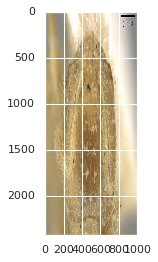

In [37]:
img_bg = img_bg.transpose(2, 0, 1)
plt.imshow(img_bg)